# Model 5

## Data preprocessing

In [1]:
# Setup
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import normalize
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
# device = "cpu"
print(f"DEVICE: {device}")

DEVICE: cuda


In [2]:
# Loading the MATLAB files.
xs = loadmat('xs_all.mat')
tau = loadmat('tau_all.mat')

In [3]:
class LoadXsTau(Dataset):

    def __init__(self, xs: dict, tau: dict, normalize: bool = True) -> None:
        super().__init__()
        self.tau_all = tau['tau_all'].squeeze() 
        self.xs_all = xs['xs_all'].squeeze()
        self.length = len(self.xs_all)
        self.normalize = normalize

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        xs = self.xs_all[index]
        tau = self.tau_all[index]

        if self.normalize:
            xs = normalize(xs, axis=0)
            tau = normalize(tau, axis=0)

        xs = torch.tensor(xs.T, dtype=torch.float32)
        tau = torch.tensor(tau.T, dtype=torch.float32)

        return xs, tau

In [4]:
dataset = LoadXsTau(xs, tau, normalize=True)
train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dataloader= DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader= DataLoader(test_data, batch_size=32, shuffle=True)

print(f"Lenght of train data: {len(train_dataloader)}")
print(f"Lenght of test data: {len(test_dataloader)}")

Lenght of train data: 25
Lenght of test data: 7


## Creating the Model

In [5]:
class ModelA(nn.Module):

    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(12, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
model = ModelA().to(device)
# model.state_dict()

In [7]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 400 == 0:
        #     print(f"Looked at {batch * len(X)}/{len(dataloader.dataset)} samples")

        return loss

def test(dataloader, model, loss_fn):
    model.eval()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

    with torch.inference_mode():
        test_pred = model(X)
        test_loss = loss_fn(test_pred, y)

    return test_loss


In [9]:
epochs = 100
loss_overall = []
loss_overall_test = []

for epoch in tqdm(range(epochs), leave=False):
    loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    if epoch % 20 == 0:
        print(f"EPOCH {epoch+1}")
        print(f"Epoch: {epoch+1} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")
        print("-"*50)
    loss_overall.append(loss.item())
    loss_overall_test.append(test_loss.item())
    
print("Done!")

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 1
Epoch: 1 | Train loss: 0.29724, Test loss: 0.27659
--------------------------------------------------
EPOCH 21
Epoch: 21 | Train loss: 0.12984, Test loss: 0.12087
--------------------------------------------------
EPOCH 41
Epoch: 41 | Train loss: 0.01853, Test loss: 0.01384
--------------------------------------------------
EPOCH 61
Epoch: 61 | Train loss: 0.00736, Test loss: 0.00695
--------------------------------------------------
EPOCH 81
Epoch: 81 | Train loss: 0.00207, Test loss: 0.00315
--------------------------------------------------
Done!


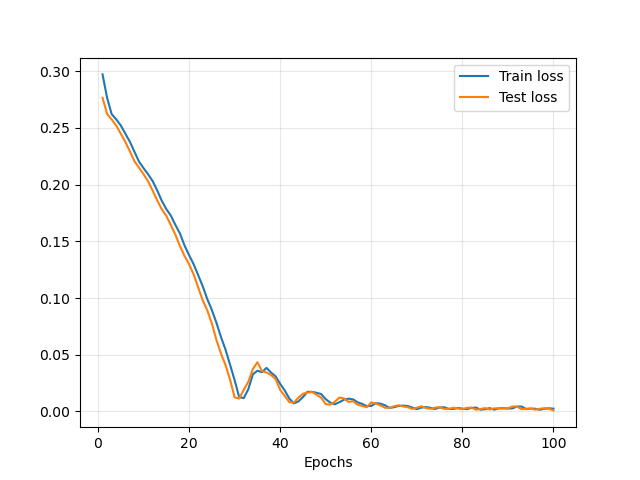

In [10]:
%matplotlib ipympl
t = np.linspace(1, epochs, epochs)

plt.plot(t, loss_overall, label='Train loss')
plt.plot(t, loss_overall_test, label='Test loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [11]:
pd.DataFrame(test_data[150][0])

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
1,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
2,0.000000,0.000000e+00,1.318707e-02,0.000000,0.000000,-4.324764e-02,0.000000e+00,0.000000e+00,0.000013,0.000000,0.000000,9.989774e-01
3,0.000000,0.000000e+00,2.623564e-02,-0.002373,0.068246,-8.604107e-02,0.000000e+00,0.000000e+00,0.000052,-0.000002,0.000068,9.936023e-01
4,0.000002,9.008478e-07,3.884499e-02,-0.004705,0.134873,-1.273786e-01,1.521197e-09,9.008478e-10,0.000117,-0.000009,0.000270,9.818619e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
19996,-0.078590,4.072541e-02,3.971301e-10,0.001037,0.002003,-3.200589e-07,1.516216e-01,2.260552e-01,0.958149,0.003957,-0.002058,5.707880e-07
19997,-0.078631,4.064798e-02,3.900970e-10,0.001035,0.002004,-3.212003e-07,1.514653e-01,2.261378e-01,0.958154,0.003959,-0.002054,5.701498e-07
19998,-0.078672,4.057051e-02,3.830622e-10,0.001033,0.002005,-3.223404e-07,1.513088e-01,2.262202e-01,0.958160,0.003962,-0.002050,5.695094e-07
19999,-0.078712,4.049300e-02,3.760258e-10,0.001031,0.002006,-3.234793e-07,1.511522e-01,2.263025e-01,0.958165,0.003964,-0.002046,5.688667e-07


In [12]:
model.eval()

with torch.inference_mode():
    my_inference = model(test_data[150][0].to(device))

In [13]:
pd.DataFrame(my_inference.to("cpu")).head()

,0,1,2,3
0,0.984357,0.007022,0.007364,-0.014998
1,0.984357,0.007022,0.007364,-0.014998
2,0.986718,0.007260,0.007744,-0.014526
3,0.987007,0.004646,0.008021,-0.013566
4,0.986334,0.003266,0.008238,-0.013147


In [14]:
my_inference[:,0]

tensor([0.9844, 0.9844, 0.9867,  ..., 0.9998, 0.9998, 0.9997], device='cuda:0')

In [15]:
t = np.arange(0,20001,1)

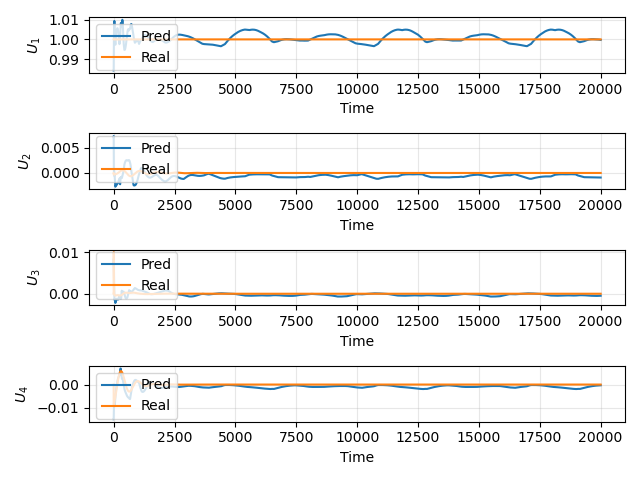

In [16]:
fig, ax = plt.subplots(4,1)

for i in range(4):
    ax[i].plot(t, my_inference[:,i].to("cpu"), label="Pred")
    ax[i].plot(t, test_data[150][1][:,i], label="Real")
    ax[i].set_ylabel(f"$U_{i+1}$")
    ax[i].set_xlabel("Time")
    ax[i].legend()
    ax[i].grid(alpha=0.3)

fig.tight_layout()